**Hamza Chikhaoui**

**Student ID : 260912960**

**COMP 565 Assignment 5**

#Imports and preprocessing

In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import random
from collections import Counter

In [ ]:
mimic_3_diagnoses_ICD = pd.read_csv('./MIMIC3_DIAGNOSES_ICD_subset.csv.gz',compression='gzip', dtype={'SUBJECT_ID':str, 'ICD9_CODE':str})
d_ICD_diagnoses = pd.read_csv('/content/D_ICD_DIAGNOSES.csv.gz', compression='gzip')

In [ ]:
mimic_3_diagnoses_ICD.head()

,SUBJECT_ID,ICD9_CODE
0,17843,2851
1,10152,0389
2,15311,4280
3,45434,5070
4,32229,51881


In [ ]:
d_ICD_diagnoses['concatenated_code'] = d_ICD_diagnoses['ICD9_CODE'].astype(str) + ' - ' + d_ICD_diagnoses['SHORT_TITLE']
#d_ICD_diagnoses = d_ICD_diagnoses.sort_values(by=['ICD9_CODE']) # Use sort_values() to sort the DataFrame by 'ICD9_CODE'
d_ICD_diagnoses.head()


,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE,concatenated_code
0,55,0065,Amebic brain abscess,Amebic brain abscess,0065 - Amebic brain abscess
1,56,0066,Amebic skin ulceration,Amebic skin ulceration,0066 - Amebic skin ulceration
2,57,0068,Amebic infection NEC,Amebic infection of other sites,0068 - Amebic infection NEC
3,58,0069,Amebiasis NOS,"Amebiasis, unspecified",0069 - Amebiasis NOS
4,59,0070,Balantidiasis,Balantidiasis,0070 - Balantidiasis


In [ ]:
print(f'the row of d_ICD_diagnoses with ICD9_CODES = 331 is {d_ICD_diagnoses[d_ICD_diagnoses["ICD9_CODE"] == "3310"]["concatenated_code"].iloc[0]}')
print(f'the row of d_ICD_diagnoses with ICD9_CODES = 332 is {d_ICD_diagnoses[d_ICD_diagnoses["ICD9_CODE"] == "3320"]["concatenated_code"].iloc[0]}')
print(f'the row of d_ICD_diagnoses with ICD9_CODES = 340 is {d_ICD_diagnoses[d_ICD_diagnoses["ICD9_CODE"] == "340"]["concatenated_code"].iloc[0]}')

storing_dict = [str(f'ICD9 Code : {d_ICD_diagnoses[d_ICD_diagnoses["ICD9_CODE"] == "3310"]["concatenated_code"].iloc[0]}'),
                str(f'ICD9 Code : {d_ICD_diagnoses[d_ICD_diagnoses["ICD9_CODE"] == "3320"]["concatenated_code"].iloc[0]}'),
                str(f'ICD9 Code : {d_ICD_diagnoses[d_ICD_diagnoses["ICD9_CODE"] == "340"]["concatenated_code"].iloc[0]}')]

the row of d_ICD_diagnoses with ICD9_CODES = 331 is 3310 - Alzheimer's disease
the row of d_ICD_diagnoses with ICD9_CODES = 332 is 3320 - Paralysis agitans
the row of d_ICD_diagnoses with ICD9_CODES = 340 is 340 - Multiple sclerosis


In [ ]:
mimic_3_diagnoses_ICD['ICD9_CODE'] = mimic_3_diagnoses_ICD['ICD9_CODE'].astype(str)
d_ICD_diagnoses['ICD9_CODE'] = d_ICD_diagnoses['ICD9_CODE'].astype(str)
print(f'type of the ICD98_CODE in mimic_3_diagnoses_ICD is {mimic_3_diagnoses_ICD["ICD9_CODE"].dtype}')
print(f'type of the ICD98_CODE in d_ICD_diagnoses is {d_ICD_diagnoses["ICD9_CODE"].dtype}')

type of the ICD98_CODE in mimic_3_diagnoses_ICD is object
type of the ICD98_CODE in d_ICD_diagnoses is object


In [ ]:
print(f'number of unique ICD_9 codes in mimic_3_diagnoses_ICD M =  {len(mimic_3_diagnoses_ICD["ICD9_CODE"].unique())}')
print(f'the number of unique patients based on subject ID is D = {len(mimic_3_diagnoses_ICD["SUBJECT_ID"].unique())}')

number of unique ICD_9 codes in mimic_3_diagnoses_ICD M =  389
the number of unique patients based on subject ID is D = 689


In [ ]:
patients = mimic_3_diagnoses_ICD['SUBJECT_ID'].astype(str).unique() #i.e. the documents d sum up to D
ICD_codes = mimic_3_diagnoses_ICD['ICD9_CODE'].astype(str).unique() #i.e. the words w summing up to M

num_words = len(ICD_codes)# 389
num_documents = len(patients)#689

print(f'number of unique ICD_9 codes in mimic_3_diagnoses_ICD M  =  {num_words} (i.e. num_words)')
print(f'the number of unique patients based on subject ID is D = {num_documents} (i.e. num_documents)')


number of unique ICD_9 codes in mimic_3_diagnoses_ICD M  =  389 (i.e. num_words)
the number of unique patients based on subject ID is D = 689 (i.e. num_documents)


# 1. Implementing the collapsed Gibbs sampling LDA

In [ ]:
def dict_generator_ndk(patient_dic):
    ndk_dict = {topic: Counter() for topic in range(1, K + 1)}
    for patient, topic_element_pair in patient_dic.items():
        for ICD_code, topic in topic_element_pair:
            ndk_dict[topic][patient] += 1
    return ndk_dict

def dict_generator_nwk(patient_dic):
    nwk_dict = {topic: Counter() for topic in range(1, K + 1)}
    for patient, topic_element_pair in patient_dic.items():
        for ICD_code, topic in topic_element_pair:
            nwk_dict[topic][ICD_code] += 1
    return nwk_dict

In [ ]:
#Starting off by selecting some hyperparameters
a = 1 #alpha
b = 0.001 #beta
K = 5 #number of topics
D = num_documents #number of unique patients
M = num_words #number of unique ICD_9 codes
num_iterations = 100


patient_dic = {}
for patient in patients:
    ICD_codes_in_patient = ( mimic_3_diagnoses_ICD[mimic_3_diagnoses_ICD["SUBJECT_ID"].astype(str) == patient]["ICD9_CODE"].astype(str).to_list())
    patient_dic[patient] = [[ICD_code, random.randint(1, K)] for ICD_code in ICD_codes_in_patient]

#Initialize n_dk and n_wk
n_dk = dict_generator_ndk(patient_dic)
n_wk = dict_generator_nwk(patient_dic)

#Start of the loop
for i in range (num_iterations):
    ICD_by_topic_total_count = {}
    for topic in range(1, K + 1):
        ICD_by_topic_total_count[topic] = sum([b + n_wk[topic][code] for code in ICD_codes])
    for patient in patients:
        for code_topic_pair in patient_dic[patient]:
            code = code_topic_pair[0]
            assigned_topic = code_topic_pair[1]
            gammas = []
            for topic in range(1, K + 1):
                current_ndk = n_dk[topic] [patient]
                current_nwk = n_wk[topic][code]
                current_ICD_by_topic_total_count = ICD_by_topic_total_count[topic]
                if assigned_topic == topic:
                    current_ndk -= 1
                    current_nwk -= 1
                    current_ICD_by_topic_total_count -= 1
                gammas.append((a + current_ndk) * (b + current_nwk) / current_ICD_by_topic_total_count)

            gammas = list(np.array(gammas) / sum(gammas))
            #print(f'the sum of gammas is {sum(gammas)}')
            new_code_topic_pair = np.random.choice(np.arange(K), size=1, p=gammas)[0] + 1
            code_topic_pair[1] = new_code_topic_pair #update topic

    #Updating n_dk and n_wk
    n_dk = dict_generator_ndk(patient_dic)
    n_wk = dict_generator_nwk(patient_dic)

In [ ]:

theta = {}
phi = {}

for topic in range(1, K + 1):
  theta[topic] = {}
  phi[topic] = {}
  for patient in patients:
    theta[topic][patient] = (a + n_dk[topic][patient]) / ((K * a) +sum(n_dk[t][patient] for t in range(1, K + 1)))
  for code in ICD_codes:
      phi[topic][code] = (b+ n_wk[topic][code]) / ((M * b) + sum(n_wk[topic][code] for code in ICD_codes))

#print(f'the final theta is {theta}')
#print(f'the final phi is {phi} ')

In [ ]:
theta_dk_df = pd.DataFrame(theta)
phi_wk_df = pd.DataFrame(phi)

theta_dk_df#Storing theta as df


,1,2,3,4,5
17843,0.125000,0.125000,0.250000,0.250000,0.250000
10152,0.285714,0.142857,0.142857,0.142857,0.285714
15311,0.166667,0.166667,0.166667,0.333333,0.166667
45434,0.166667,0.166667,0.333333,0.166667,0.166667
32229,0.166667,0.166667,0.333333,0.166667,0.166667
...,...,...,...,...,...
13339,0.166667,0.166667,0.333333,0.166667,0.166667
59761,0.166667,0.166667,0.166667,0.166667,0.333333
1338,0.166667,0.166667,0.166667,0.166667,0.333333
26042,0.166667,0.166667,0.166667,0.166667,0.333333


In [ ]:
phi_wk_df #Storing phi as df

,1,2,3,4,5
2851,0.000005,0.000005,0.031340,0.000006,0.000005
0389,0.073927,0.000005,0.000004,0.000006,0.000005
4280,0.000005,0.078205,0.000004,0.056699,0.000005
5070,0.000005,0.000005,0.044769,0.017014,0.000005
51881,0.000005,0.000005,0.035816,0.000006,0.000005
...,...,...,...,...,...
85205,0.000005,0.000005,0.004481,0.000006,0.000005
5579,0.000005,0.000005,0.000004,0.005675,0.000005
85305,0.000005,0.000005,0.004481,0.000006,0.000005
34839,0.000005,0.000005,0.004481,0.000006,0.000005


# 2. Visualizing the top 10 ICD codes under each topic

In [ ]:
#For each topic k, choose the top 10 ICD-9 codes defined under phi_wk

top_10_per_topic = []
corresponding_indices_of_phi = []
for k in range(K):
    top_10_indices = phi_wk_df.iloc[:, k].argsort()[-10:][::-1]
    corresponding_indices_of_phi.append(top_10_indices)
    top_10_codes = [ICD_codes[i] for i in top_10_indices]
    top_10_per_topic.append(top_10_codes)

#top_10_per_topic

In [ ]:
ICD = d_ICD_diagnoses['ICD9_CODE'].unique()

elements_to_fix = []
closest_element = None
for l in top_10_per_topic:
  for element in l:
    if element not in ICD:
      print(f'element {element} not in ICD')
      elements_to_fix.append(element)
      # Use .str accessor to apply startswith to each element of the Series
      closest_element_series = d_ICD_diagnoses['ICD9_CODE'].astype(str).str.startswith(str(element))

      # Find the first matching ICD9_CODE
      closest_element = d_ICD_diagnoses.loc[closest_element_series, 'ICD9_CODE'].iloc[0] if closest_element_series.any() else None
      if closest_element is not None :
        print(f'replacement found to be {closest_element}') #Print the replacement to make sure it is satisfying
        for sublist in top_10_per_topic:
            for i in range(len(sublist)):
                if sublist[i] == element:
                    sublist[i] = closest_element

      else:
        print(f'No replacement found for {element}')

element 2765 not in ICD
replacement found to be 27650


In [ ]:
lookup = d_ICD_diagnoses.set_index('ICD9_CODE')['concatenated_code'].to_dict()
mapped_icd_lists = [[lookup[code] for code in icd_codes] for icd_codes in top_10_per_topic]

#mapped_icd_lists

In [ ]:
matrix_heatmap = np.zeros((5, 50))
for k in range(5):
  for i in range(10):
    index = int(corresponding_indices_of_phi[k][i])
    phi_value = phi_wk_df.iloc[index, k]
    matrix_heatmap[k, 10*k + i] = phi_wk_df.iloc[index, k]


<ipython-input-17-6db3e64bbcb4>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  index = int(corresponding_indices_of_phi[k][i])


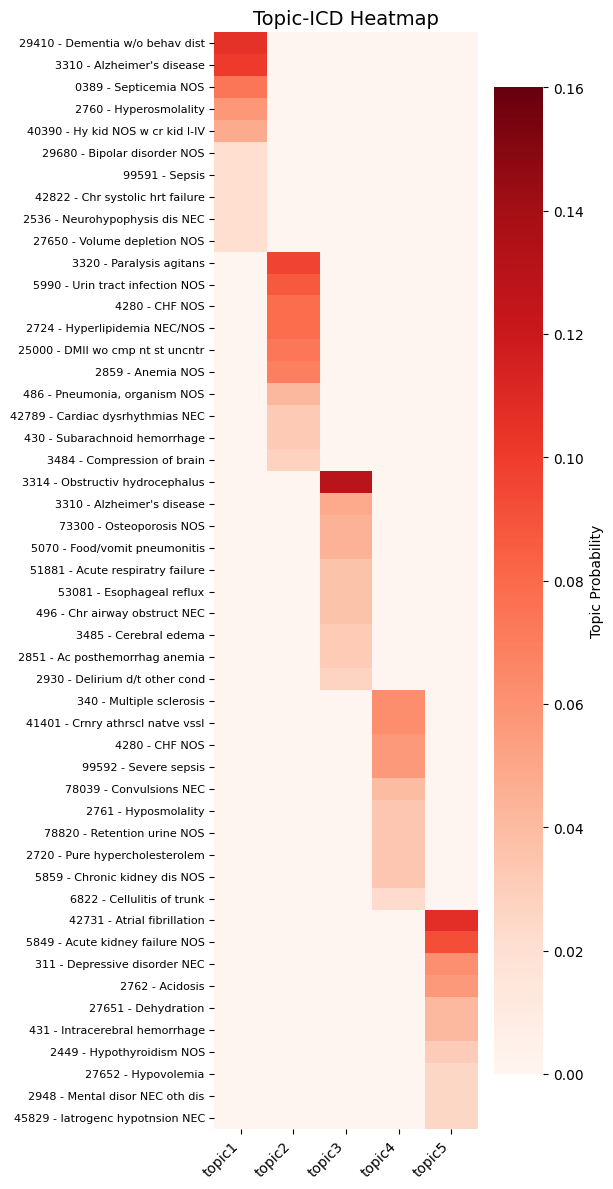

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

heatmap = matrix_heatmap.T
flattened_list = [item for sublist in mapped_icd_lists for item in sublist]

#Plot heatmap
plt.figure(figsize=(6, 12))

ax = sns.heatmap(
    heatmap,
    annot=False,
    cmap="Reds",  # Red color gradient
    xticklabels=["topic1", "topic2", "topic3", "topic4", "topic5"],
    yticklabels=flattened_list,
    cbar_kws={"label": "Topic Probability"},
    vmax = 0.16,
    vmin = 0
)


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax.tick_params(axis="y", labelsize=8)
plt.title("Topic-ICD Heatmap", fontsize=14)
plt.xlabel("")
plt.ylabel("")

plt.tight_layout()
plt.show()



# 3. Correlating topics with the target codes

In [ ]:


target_codes = ['331', '332', '340']

for code in target_codes:
  mimic_3_diagnoses_ICD[code] = mimic_3_diagnoses_ICD['ICD9_CODE'].astype(str).str.startswith(code).astype(int)

mimic_3_diagnoses_ICD

,SUBJECT_ID,ICD9_CODE,331,332,340
0,17843,2851,0,0,0
1,10152,0389,0,0,0
2,15311,4280,0,0,0
3,45434,5070,0,0,0
4,32229,51881,0,0,0
...,...,...,...,...,...
995,26042,5849,0,0,0
996,83875,486,0,0,0
997,50391,29410,0,0,0
998,25030,78039,0,0,0


In [ ]:
count_mimic_3_diagnoses_ICD = (
    mimic_3_diagnoses_ICD.groupby("SUBJECT_ID")[
        [target_codes[0], target_codes[1], target_codes[2]]
    ]
    .sum()
    .reset_index()
)

theta_mimic_3_diagnoses_ICD = pd.DataFrame()
names = pd.Index(sorted(theta[1].keys()))
theta_mimic_3_diagnoses_ICD["SUBJECT_ID"] = names

for i in range(1, K + 1):
    topic = f"Topic {i}"
    values = pd.Index([v for (_, v) in sorted(theta[i].items(), key=lambda x: x[0])])
    theta_mimic_3_diagnoses_ICD[topic] = values


#merge the two DataFrames on SUBJECT_ID to align rows
merged_mimic_3_diagnoses_ICD = pd.merge(theta_mimic_3_diagnoses_ICD, count_mimic_3_diagnoses_ICD, on="SUBJECT_ID")

#drop SUBJECT_ID to focus only on numerical data
merged_mimic_3_diagnoses_ICD_numeric = merged_mimic_3_diagnoses_ICD.drop(columns=["SUBJECT_ID"])

# Calculate correlations between topic columns and ICD count columns
correlation_matrix = merged_mimic_3_diagnoses_ICD_numeric.corr()
correlation_matrix = correlation_matrix.head()
correlation_matrix = correlation_matrix[
    ["331", "332", "340"]
]


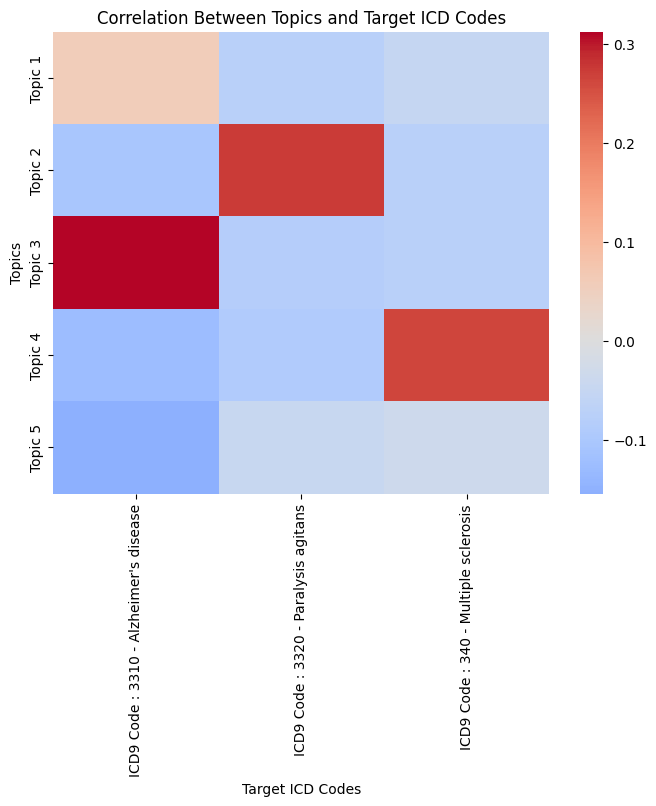

In [ ]:
#Create a correlation matrix between topics and our selected ICD codes
icd_labels = storing_dict
topic_labels = [f'Topic {i+1}' for i in range(K)]


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, xticklabels=icd_labels, yticklabels=topic_labels, cmap='coolwarm', center = 0)
plt.title('Correlation Between Topics and Target ICD Codes')
plt.xlabel('Target ICD Codes')
plt.ylabel('Topics')
plt.show()

# 4. Visualizing patient topic mixtures

In [ ]:
top_10_per_topic = []
corresponding_indices_of_phi = []
for k in range(K):
    top_10_indices = phi_wk_df.iloc[:, k].argsort()[-100:][::-1]
    corresponding_indices_of_phi.append(top_10_indices)
    top_10_codes = [ICD_codes[i] for i in top_10_indices]
    top_10_per_topic.append(top_10_codes)

ICD = d_ICD_diagnoses['ICD9_CODE'].unique()

elements_to_fix = []
closest_element = None
for l in top_10_per_topic:
  for element in l:
    if element not in ICD:
      print(f'element {element} not in ICD')
      elements_to_fix.append(element)
      # Use .str accessor to apply startswith to each element of the Series
      closest_element_series = d_ICD_diagnoses['ICD9_CODE'].astype(str).str.startswith(str(element))

      # Find the first matching ICD9_CODE
      closest_element = d_ICD_diagnoses.loc[closest_element_series, 'ICD9_CODE'].iloc[0] if closest_element_series.any() else None
      if closest_element is not None :
        print(f'replacement found to be {closest_element}')
        for sublist in top_10_per_topic:
            for i in range(len(sublist)):
                if sublist[i] == element:
                    sublist[i] = closest_element

      else:
        print(f'No replacement found for {element}')


lookup = d_ICD_diagnoses.set_index('ICD9_CODE')['concatenated_code'].to_dict()
mapped_icd_lists = [[lookup[code] for code in icd_codes] for icd_codes in top_10_per_topic]




element 2765 not in ICD
replacement found to be 27650
element 2773 not in ICD
replacement found to be 27730
element 5185 not in ICD
replacement found to be 51851
element 5191 not in ICD
replacement found to be 51911
element 7845 not in ICD
replacement found to be 78451
element 0414 not in ICD
replacement found to be 04141
element 2880 not in ICD
replacement found to be 28800
element 7070 not in ICD
replacement found to be 70700
element 2841 not in ICD
replacement found to be 28411
element 2766 not in ICD
replacement found to be 27661
element 5997 not in ICD
replacement found to be 59970


In [ ]:
merged_df = pd.DataFrame()
for topic in range (1, K+1):
  new_df = theta_dk_df.reset_index().sort_values(by=[topic], ascending=False).head(100)
  new_df.columns = new_df.columns[:0].tolist() + ['SUBJECT_ID'] + new_df.columns[1:].tolist()
  merged_df = pd.concat((merged_df, pd.merge(new_df, count_mimic_3_diagnoses_ICD, on = "SUBJECT_ID")))
merged_df.drop(columns = ['SUBJECT_ID'], inplace = True)
merged_df


,1,2,3,4,5,331,332,340
0,0.555556,0.111111,0.111111,0.111111,0.111111,0,0,0
1,0.500000,0.125000,0.125000,0.125000,0.125000,1,0,0
2,0.428571,0.142857,0.142857,0.142857,0.142857,0,0,0
3,0.428571,0.142857,0.142857,0.142857,0.142857,1,0,0
4,0.428571,0.142857,0.142857,0.142857,0.142857,1,0,0
...,...,...,...,...,...,...,...,...
95,0.166667,0.166667,0.166667,0.166667,0.333333,0,0,0
96,0.166667,0.166667,0.166667,0.166667,0.333333,0,0,0
97,0.166667,0.166667,0.166667,0.166667,0.333333,0,0,0
98,0.166667,0.166667,0.166667,0.166667,0.333333,0,0,0


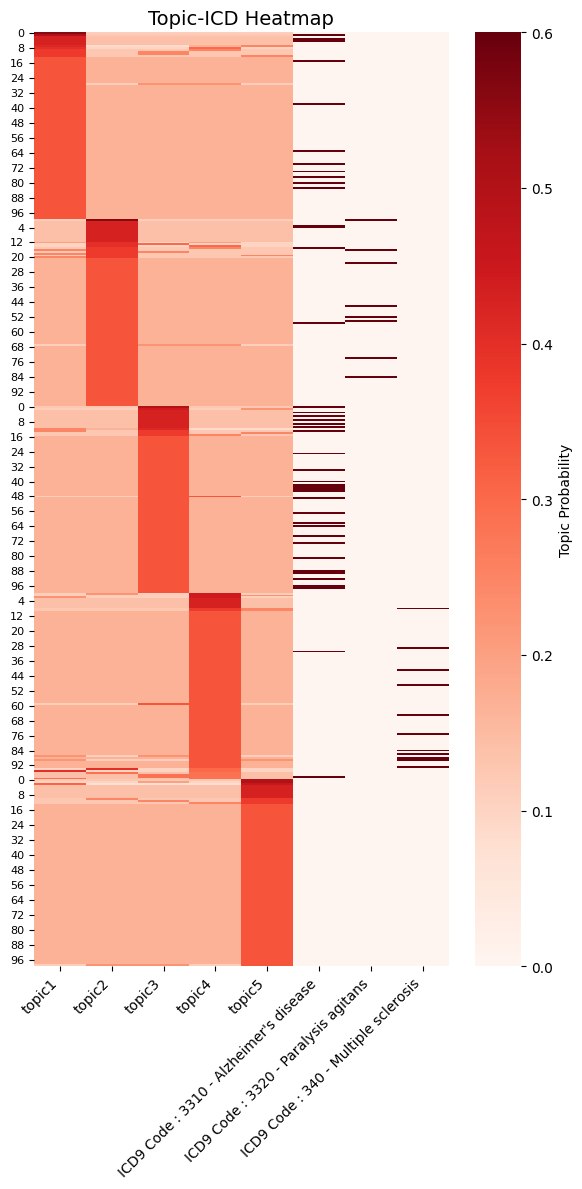

In [ ]:

flattened_list = [item for sublist in mapped_icd_lists for item in sublist]

# Plot heatmap
plt.figure(figsize=(6, 12))

ax = sns.heatmap(
    merged_df,
    annot=False,
    cmap="Reds",  # Red color gradient
    xticklabels=["topic1", "topic2", "topic3", "topic4", "topic5",storing_dict[0], storing_dict[1], storing_dict[2] ],
    cbar_kws={"label": "Topic Probability"},
    vmin = 0,
    vmax = 0.6)


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax.tick_params(axis="y", labelsize=8)
plt.title("Topic-ICD Heatmap", fontsize=14)
plt.xlabel("")
plt.ylabel("")

plt.tight_layout()
plt.show()